# Logo Detection

In this notebook we develop a model which is able to locate and lable company logos within static images.

## Import dependencies

In [1]:
import os
import json
import random

import cv2
import pandas as pd
import matplotlib.pylab as plt
from IPython.display import Image

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

## Load in the training data

The training data was simulated by applying transformations to the logos and laying them on top of various backgrounds. See [this notebook](./Training.ipynb) for more info on the training data.

In [2]:
def get_dicts(IMG_DIR):
    """Returns a list of dicts - one for each image
    Each dict contains labels and bounding boxes
    
    Each folder (train, val, test) contains a data.json file
    """

    path = os.path.join(IMG_DIR, 'data.json')
    dataset_dict = json.load(open(path))
    
    for item in dataset_dict:
        for ann in item['annotations']:
            ann['bbox_mode'] = BoxMode.XYXY_ABS    

    return dataset_dict


def get_metadata(dataset_name):
    metadata = MetadataCatalog.get(dataset_name)

    return metadata        


def sample_plot(dataset_dict, metadata, LOC):
    d = random.sample(dataset_dict, 1)[0]
    img = cv2.imread(os.path.join(LOC, d["file_name"]))
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::1])
    
    
def register(IMG_DIR, class_names, subfolders=['train', 'test']):
    """Register datasets for detectron2"""
    
    for d in subfolders:
        DatasetCatalog.register(f"{IMG_DIR}_{d}", lambda d=d: get_dicts(f'{IMG_DIR}/{d}'))
        MetadataCatalog.get(f"{IMG_DIR}_{d}").set(thing_classes=class_names)

In the next cell we load in the information about the training data. For each image in training data this information includes:
1. the file name,
2. the logo lables, 
3. the coordinates of the lower left and upper right corners of the bounding box,

In [3]:
logo_train = get_dicts('logo_detector/combined/train')

logo_train_metadata = get_metadata('logo_detector/combined_train')

labels = list(pd.read_csv\
              ('logo_detector/combined/train/labels.csv')\
              ['class'].unique())

['sas', 'rh', 'anaconda', 'cloudera']


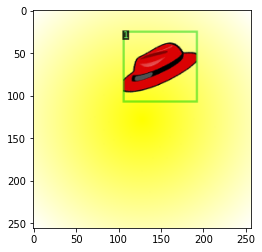

In [4]:
random.seed("summit20")
sample_plot(logo_train, logo_train_metadata,'./')
print(labels)

## Training the model

In [5]:
def prepare_for_training(N_iter,
                         output_dir,
                         train_dataset_name,
                         N_classes,
                         start_training=False):
    cfg = get_cfg()
    cfg.MODEL.DEVICE='cpu'
    cfg.merge_from_file(model_zoo.get_config_file\
                        ("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
    cfg.OUTPUT_DIR = output_dir
    cfg.DATASETS.TRAIN = (train_dataset_name,)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url\
                        ("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025  
    cfg.SOLVER.MAX_ITER = N_iter   
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = N_classes

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)

    if start_training:
        trainer.train()

    return trainer, cfg 

In [6]:
register('logo_detector/combined/', labels, ['train', 'test'])

N_classes = 4
trainer, cfg = prepare_for_training(2, 
                                    'logo_detector_output', 
                                    'logo_detector/combined/_train', 
                                    N_classes, 
                                    start_training=True)

[03/26 11:58:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[03/26 11:58:54 d2.data.build]: Removed 0 images with no usable annotations. 512 images left.
[03/26 11:58:54 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    sas     | 128          |     rh     | 128          |  anaconda  | 128          |
|  cloudera  | 128          |            |              |            |              |
|   total    | 512          |            |              |            |              |
[03/26 11:58:54 d2.data.common]: Serializing 512 elements to byte tensors and concatenating them all ...
[03/26 11:58:54 d2.data.common]: Serialized dataset takes 0.11 MiB
[03/26 11:58:54 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/26 11:58:54 d2.data.b

'roi_heads.box_predictor.cls_score.weight' has shape (81, 2048) in the checkpoint but (5, 2048) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (5,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 2048) in the checkpoint but (16, 2048) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (16,) in the model! Skipped.


[03/26 11:58:55 d2.engine.train_loop]: Starting training from iteration 0
[03/26 12:00:05 d2.utils.events]:  eta: N/A  iter: 1  total_loss: 1.963  loss_cls: 1.519  loss_box_reg: 0.320  loss_rpn_cls: 0.103  loss_rpn_loc: 0.021    data_time: 0.5572  lr: 0.000000  
[03/26 12:00:05 d2.engine.hooks]: Total training time: 0:00:00 (0:00:00 on hooks)


## Validating the model

Next, we see how well our model we just trained performs on labled data.

In [7]:
def prepare_for_inference(cfg, test_dataset_name, threshold=0.70):
    print(f"Reading weights from output dir: {cfg.OUTPUT_DIR}")
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold   # set the testing threshold for this model
    cfg.DATASETS.TEST = (test_dataset_name, )
    predictor = DefaultPredictor(cfg)    

    return predictor


def infer_img(predictor, img_filename, metadata):
    img = cv2.imread(img_filename)
    outputs = predictor(img)

    v = Visualizer(img[:,:,::-1], metadata=metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image())
    
    return outputs

In the next cell, we load in test data and define a threshold of certainty which must be met for a bounding box to be drawn. 

In [13]:
predictor = prepare_for_inference(cfg, 'logo_detector/combined/_test', threshold=0.34)
logo_test_metadata = get_metadata('logo_detector/combined_test')

Reading weights from output dir: logo_detector_output


Inspecting an image:

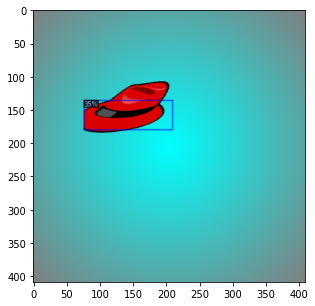

In [14]:
plt.figure(figsize=(5,5))
_ = infer_img(predictor, 'logo_detector/combined/test/rh_bgrlal.png', logo_test_metadata)

### Performance Metrics

We look at two perfomance metrics for the model: The first is a confusion matrix, showing the proportion of correctly classified and missclasified logos; the second is the average overlap between the bounding boxes drawn on our training data and the boxes identified by the model.

'sas': 82.5824281290984,
'rh': 79.00924387840708,
'anaconda': 86.84715918153037,
'cloudera': 70.13753486443517

### Testing on new data

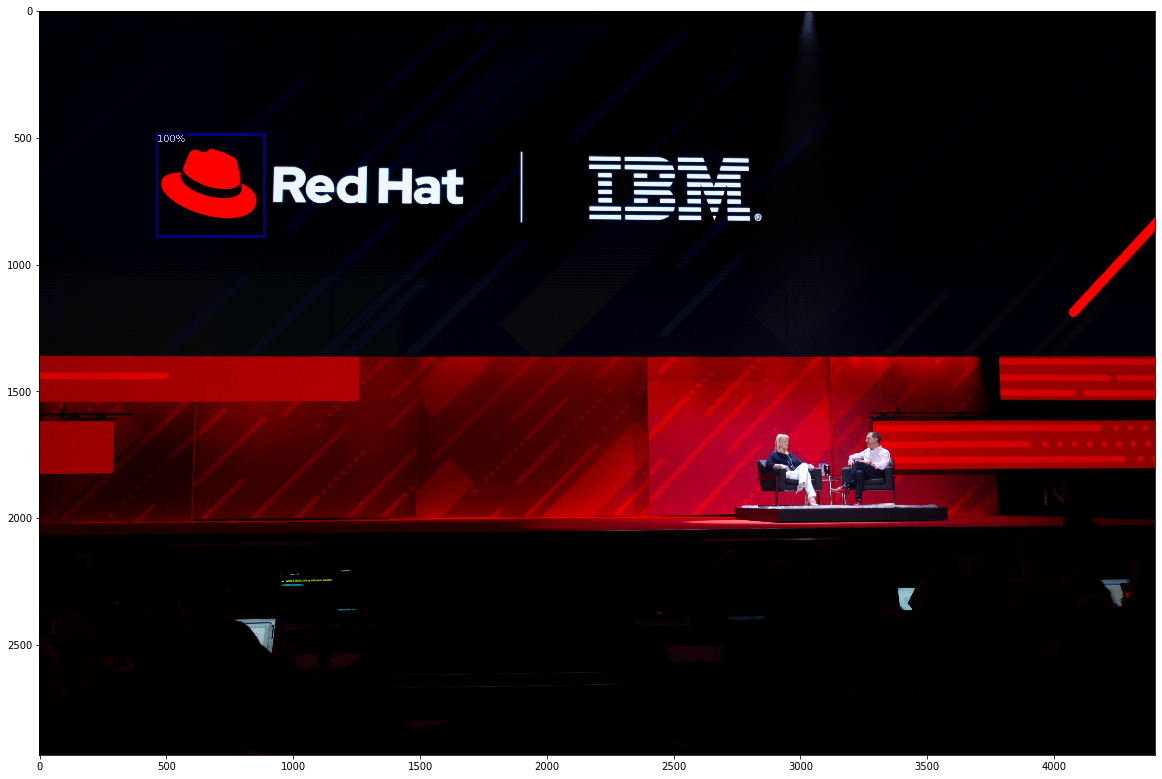

In [10]:
Image(filename='./Summit-2.png', width=800, height=800)

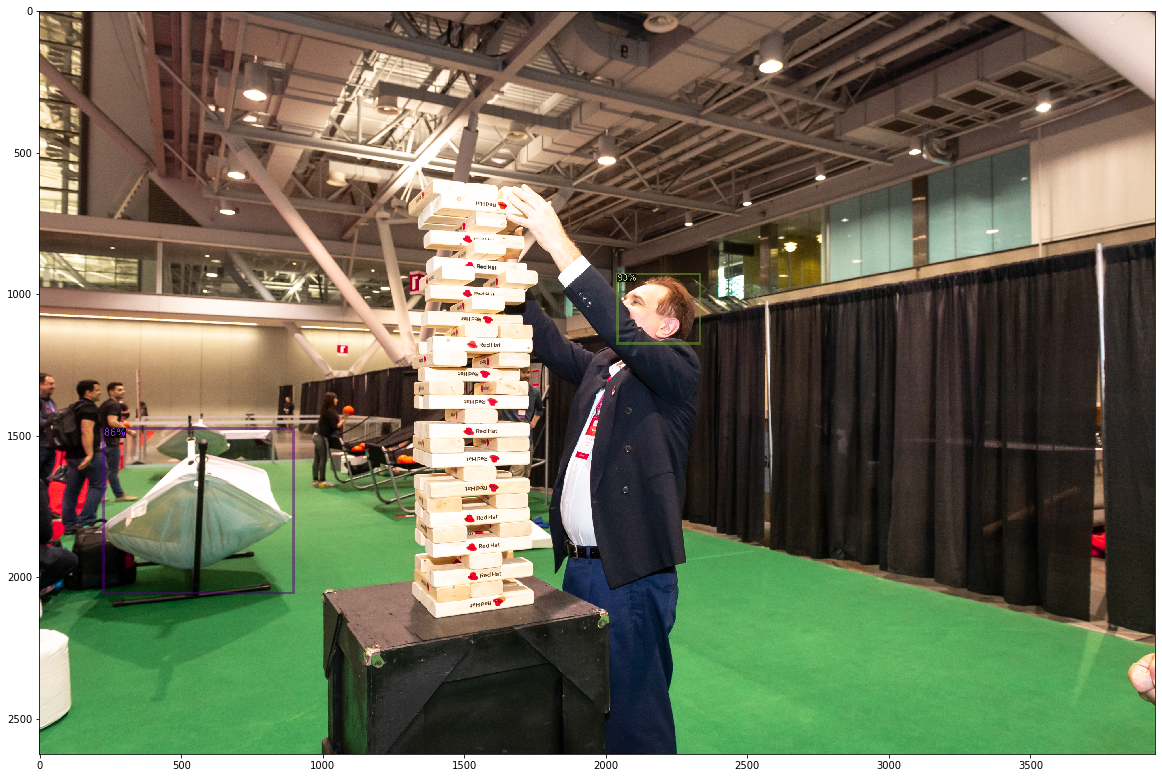

In [11]:
Image(filename='./Summit-3.png', width=800, height=800)

## Publish the model

This is a two stage process:
1. save model binary to ceph bucket
2. submit a PR showing the model performance data

In [12]:
out = json.dumps({'accuracy': 0.8})
METRIC_FILE = '../outputs/metrics'
with open(METRIC_FILE, 'w') as f:
    f.write(out)